In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model

In [2]:
data = pd.read_csv('merged_iitp2.csv')
water = data.drop(['ELEC_diff','ELEC_before','ELEC','HOT_diff','HOT_before','HOT','WATER_diff','WATER_before'], axis=1)
hot = data.drop(['ELEC_diff','ELEC_before','ELEC','WATER_diff','WATER_before','WATER','HOT_diff','HOT_before'], axis=1)
elec = data.drop(['WATER_diff','WATER_before','WATER','HOT_diff','HOT_before','HOT','ELEC_diff','ELEC_before'], axis=1)

In [3]:
# water['date'] = pd.to_datetime(water.iloc[:,:4])
# d_date = water[['date']]

In [4]:
# plt.figure(figsize=(8,2))
# plt.ylabel('Target Domain D [Ton]',size=10)
# plt.plot(d_date, water['WATER'], color='purple')
# #plt.plot(water['WATER'], color='black')
# plt.rc('font',size=10)
# #plt.xticks(rotation=45)
# plt.legend()
# plt.show()

In [5]:
# plt.figure(figsize=(8,2))
# plt.ylabel('Target Domain D [Ton]',size=10)
# plt.plot(water['WATER'], color='purple')
# plt.rc('font',size=10)
# plt.legend()
# plt.show()

In [6]:
water = water.drop(['YEAR'], axis=1)
elec = elec.drop(['YEAR'], axis=1)
hot = hot.drop(['YEAR'], axis=1)

##  For Scaling

In [7]:
water_X = water.drop(['WATER'], axis=1)
water_Y = water[['WATER']]

scaler_water = MinMaxScaler()
scaler_water.fit(water_X)
scaled_water_X = scaler_water.transform(water_X)

new_water_X = pd.DataFrame(scaled_water_X, index=water_X.index, columns=water_X.columns)
new_water = pd.concat([new_water_X, water_Y], axis=1)

In [8]:
input_water = new_water.iloc[:-1,]
target_water = new_water[['WATER']].iloc[1:]

trainX_water, testX_water, trainY_water, testY_water = train_test_split(input_water,target_water,test_size=0.3,shuffle=False,random_state=0)

In [9]:
def buildDataSet(input, target, seqLength):
    xdata = []
    ydata = []
    for i in range(len(input) - seqLength):
        tx = input.iloc[i:i+seqLength]
        ty = target.iloc[i+seqLength-1]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)

In [10]:
trainx_water, trainy_water = buildDataSet(trainX_water, trainY_water, 24)
testx_water, testy_water = buildDataSet(testX_water, testY_water, 24)

In [11]:
src_model = load_model('DHW_source.h5')

In [12]:
for layer in src_model.layers:
    print('Name:', layer.name, 'Trainable:', layer.trainable)

Name: input_2 Trainable: True
Name: conv1d_3 Trainable: True
Name: max_pooling1d_3 Trainable: True
Name: conv1d_4 Trainable: True
Name: max_pooling1d_4 Trainable: True
Name: conv1d_5 Trainable: True
Name: max_pooling1d_5 Trainable: True
Name: lstm_6 Trainable: True
Name: lstm_7 Trainable: True
Name: lstm_8 Trainable: True
Name: lstm_9 Trainable: True
Name: lstm_10 Trainable: True
Name: lstm_11 Trainable: True
Name: flatten_1 Trainable: True
Name: dense_1 Trainable: True


In [13]:
for layer in src_model.layers[:7]:
    layer.trainable = False

for layer in src_model.layers:
    print('Name:', layer.name, 'Trainable:', layer.trainable)

Name: input_2 Trainable: False
Name: conv1d_3 Trainable: False
Name: max_pooling1d_3 Trainable: False
Name: conv1d_4 Trainable: False
Name: max_pooling1d_4 Trainable: False
Name: conv1d_5 Trainable: False
Name: max_pooling1d_5 Trainable: False
Name: lstm_6 Trainable: True
Name: lstm_7 Trainable: True
Name: lstm_8 Trainable: True
Name: lstm_9 Trainable: True
Name: lstm_10 Trainable: True
Name: lstm_11 Trainable: True
Name: flatten_1 Trainable: True
Name: dense_1 Trainable: True


In [14]:
# # 모델 컴파일
# earlystopping = EarlyStopping(monitor='loss', patience=50)
# checkpoint = ModelCheckpoint(moniter='loss',filepath='DHW_to_new_water.h5')
# src_model.compile(loss='mae', optimizer=tf.keras.optimizers.Adamax(learning_rate=3e-4,clipnorm=1.0), metrics=['mae'])
# # 모델 요약 정보 출력
# hist = src_model.fit(trainx_water, trainy_water, epochs=200, batch_size=128, callbacks=[earlystopping,checkpoint])

In [15]:
model = load_model('DHW_to_new_water.h5')
pred = model.predict(testx_water) 
pred = np.reshape(pred,(-1,1))

real = np.array(testy_water)

82/82 [==============================] - 6s 9ms/step


In [16]:
from sklearn.metrics import mean_absolute_error
print('MAE : ', round(mean_absolute_error(real, pred),4)) 

from sklearn.metrics import mean_squared_error
print('MSE : ', round(mean_squared_error(real, pred),4))

from sklearn.metrics import r2_score 
print('R2 : ', round(r2_score(real, pred),4))

MAE :  0.8337
MSE :  1.3814
R2 :  0.896


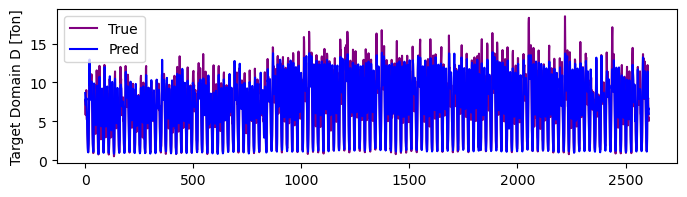

In [17]:
plt.figure(figsize=(8,2))
plt.ylabel('Target Domain D [Ton]', size=10)
plt.plot(real, color='purple',label='True')
plt.plot(pred, color='blue',label='Pred')
plt.rc('font',size=10)
plt.legend()
plt.show()